# PREDICTING THE SEVERITY OF AN ACCIDENT/COLLISION

### Import the relevant libraires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import dask.dataframe as dd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

sns.set()

### Import the dataset

In [2]:
%time data = pd.read_csv('Data-Collisions.csv')
data.info(verbose=False, memory_usage="deep")

<string>:2: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.


Wall time: 1.11 s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Columns: 38 entries, SEVERITYCODE to HITPARKEDCAR
dtypes: float64(4), int64(12), object(22)
memory usage: 288.5 MB


In [3]:
%time data = dd.read_csv('Data-Collisions.csv')
data.info(verbose=False, memory_usage="deep")

Wall time: 51.9 ms
<class 'dask.dataframe.core.DataFrame'>
Columns: 38 entries, SEVERITYCODE to HITPARKEDCAR
dtypes: object(22), float64(4), int64(12)
memory usage: 56.4 MB


C:\ProgramData\Anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


## EXPLORATORY DATA ANALYSIS

#### View the data

In [4]:
data.compute().head() #since it is a dask dataframe

C:\ProgramData\Anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


#### Shape of the data

In [5]:
data.compute().shape

C:\ProgramData\Anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


(194673, 38)

#### Describe the data

In [6]:
data.compute().describe(include = 'all')

C:\ProgramData\Anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
count,194673.000000,189339.000000,189339.000000,194673.000000,194673.000000,194673.000000,194673,194673,192747,65070.000000,...,189661,189503,4667,1.149360e+05,9333,194655,189769,194673.000000,1.946730e+05,194673
unique,NaN,NaN,NaN,NaN,NaN,NaN,194670,2,3,NaN,...,9,9,1,NaN,1,115,62,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,1780512,Matched,Block,NaN,...,Dry,Daylight,Y,NaN,Y,32,One parked--one moving,NaN,NaN,N
freq,NaN,NaN,NaN,NaN,NaN,NaN,2,189786,126926,NaN,...,124510,116137,4667,NaN,9333,27612,44421,NaN,NaN,187457
mean,1.298901,-122.330518,47.619543,108479.364930,141091.456350,141298.811381,NaN,NaN,NaN,37558.450576,...,NaN,NaN,NaN,7.972521e+06,NaN,NaN,NaN,269.401114,9.782452e+03,NaN
std,0.457778,0.029976,0.056157,62649.722558,86634.402737,86986.542110,NaN,NaN,NaN,51745.990273,...,NaN,NaN,NaN,2.553533e+06,NaN,NaN,NaN,3315.776055,7.226926e+04,NaN
min,1.000000,-122.419091,47.495573,1.000000,1001.000000,1001.000000,NaN,NaN,NaN,23807.000000,...,NaN,NaN,NaN,1.007024e+06,NaN,NaN,NaN,0.000000,0.000000e+00,NaN
25%,1.000000,-122.348673,47.575956,54267.000000,70383.000000,70383.000000,NaN,NaN,NaN,28667.000000,...,NaN,NaN,NaN,6.040015e+06,NaN,NaN,NaN,0.000000,0.000000e+00,NaN
50%,1.000000,-122.330224,47.615369,106912.000000,123363.000000,123363.000000,NaN,NaN,NaN,29973.000000,...,NaN,NaN,NaN,8.023022e+06,NaN,NaN,NaN,0.000000,0.000000e+00,NaN
75%,2.000000,-122.311937,47.663664,162272.000000,203319.000000,203459.000000,NaN,NaN,NaN,33973.000000,...,NaN,NaN,NaN,1.015501e+07,NaN,NaN,NaN,0.000000,0.000000e+00,NaN


#### Cheeck if target data is balanced or imbalanced

In [7]:
data.SEVERITYCODE.value_counts().compute()

C:\ProgramData\Anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

#### Features of the data

In [8]:
data.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

### TOO MANY FEATURES,, ONLY KEEP FEW
ADDRTYPE

LOCATION

SEVERITYCODE

COLLISIONTYPE

PERSONCOUNT

PEDCOUNT

PEDCYLCOUNT

VEHCOUNT

INJURIES

SERIOUSINJURIES

FATALITIES

JUNCTIONTYPE

INATTENTIONIND

UNDERINFL

WEATHER

ROADCOND

LIGHTCOND

PEDROWNOTGRNT

SPEEDING

HITPARKEDCAR


In [9]:
features = [ 'ADDRTYPE', 'LOCATION','COLLISIONTYPE', 'PERSONCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE',
'INATTENTIONIND', 'UNDERINFL', 'WEATHER',
'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT',
'SPEEDING', 'HITPARKEDCAR', 'SEVERITYCODE']

In [10]:
featured_data = data[features].compute()

C:\ProgramData\Anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


#### Data types of the features

In [11]:
featured_data.dtypes

ADDRTYPE          object
LOCATION          object
COLLISIONTYPE     object
PERSONCOUNT        int64
VEHCOUNT           int64
JUNCTIONTYPE      object
INATTENTIONIND    object
UNDERINFL         object
WEATHER           object
ROADCOND          object
LIGHTCOND         object
PEDROWNOTGRNT     object
SPEEDING          object
HITPARKEDCAR      object
SEVERITYCODE       int64
dtype: object

#### Check for missing values

In [12]:
featured_data.isnull().sum()

ADDRTYPE            1926
LOCATION            2677
COLLISIONTYPE       4904
PERSONCOUNT            0
VEHCOUNT               0
JUNCTIONTYPE        6329
INATTENTIONIND    164868
UNDERINFL           4884
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
PEDROWNOTGRNT     190006
SPEEDING          185340
HITPARKEDCAR           0
SEVERITYCODE           0
dtype: int64

#### Check for memory usage

In [13]:
featured_data.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194673 entries, 0 to 26415
Columns: 15 entries, ADDRTYPE to SEVERITYCODE
dtypes: int64(3), object(12)
memory usage: 142.2 MB


#### Viewing the data after selecting features

In [14]:
featured_data.head()

,ADDRTYPE,LOCATION,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,SEVERITYCODE
0,Intersection,5TH AVE NE AND NE 103RD ST,Angles,2,2,At Intersection (intersection related),NaN,N,Overcast,Wet,Daylight,NaN,NaN,N,2
1,Block,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,Sideswipe,2,2,Mid-Block (not related to intersection),NaN,0,Raining,Wet,Dark - Street Lights On,NaN,NaN,N,1
2,Block,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,Parked Car,4,3,Mid-Block (not related to intersection),NaN,0,Overcast,Dry,Daylight,NaN,NaN,N,1
3,Block,2ND AVE BETWEEN MARION ST AND MADISON ST,Other,3,3,Mid-Block (not related to intersection),NaN,N,Clear,Dry,Daylight,NaN,NaN,N,1
4,Intersection,SWIFT AVE S AND SWIFT AV OFF RP,Angles,2,2,At Intersection (intersection related),NaN,0,Raining,Wet,Daylight,NaN,NaN,N,2


### DEALING WITH MISSING VALUES

#### Check missing values

In [15]:
featured_data.isnull().sum()

ADDRTYPE            1926
LOCATION            2677
COLLISIONTYPE       4904
PERSONCOUNT            0
VEHCOUNT               0
JUNCTIONTYPE        6329
INATTENTIONIND    164868
UNDERINFL           4884
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
PEDROWNOTGRNT     190006
SPEEDING          185340
HITPARKEDCAR           0
SEVERITYCODE           0
dtype: int64

#### ADDRTYPE

In [16]:
featured_data.ADDRTYPE.unique()

array(['Intersection', 'Block', 'Alley', nan], dtype=object)

In [17]:
featured_data = featured_data.dropna(subset = ['ADDRTYPE'])

In [18]:
featured_data.isnull().sum()

ADDRTYPE               0
LOCATION             751
COLLISIONTYPE       4797
PERSONCOUNT            0
VEHCOUNT               0
JUNCTIONTYPE        4733
INATTENTIONIND    163076
UNDERINFL           4777
WEATHER             4971
ROADCOND            4903
LIGHTCOND           5058
PEDROWNOTGRNT     188083
SPEEDING          183468
HITPARKEDCAR           0
SEVERITYCODE           0
dtype: int64

#### LOCATION

In [19]:
featured_data.LOCATION.unique()

array(['5TH AVE NE AND NE 103RD ST',
       'AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N',
       '4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST', ...,
       '47TH AVE SW AND SW 98TH ST', 'NE PARK RD AND NE RAVENNA WB BV',
       'PUGET BLVD SW BETWEEN SW HUDSON ST AND DEAD END 1'], dtype=object)

In [20]:
featured_data.dropna(subset = ['LOCATION'], inplace = True)

In [21]:
featured_data.isnull().sum()

ADDRTYPE               0
LOCATION               0
COLLISIONTYPE       4793
PERSONCOUNT            0
VEHCOUNT               0
JUNCTIONTYPE        4218
INATTENTIONIND    162416
UNDERINFL           4773
WEATHER             4963
ROADCOND            4896
LIGHTCOND           5052
PEDROWNOTGRNT     187341
SPEEDING          182750
HITPARKEDCAR           0
SEVERITYCODE           0
dtype: int64

#### COLLISIONTYPE

In [22]:
featured_data.LOCATION.unique()

array(['5TH AVE NE AND NE 103RD ST',
       'AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N',
       '4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST', ...,
       '47TH AVE SW AND SW 98TH ST', 'NE PARK RD AND NE RAVENNA WB BV',
       'PUGET BLVD SW BETWEEN SW HUDSON ST AND DEAD END 1'], dtype=object)

In [23]:
featured_data.dropna(subset = ['COLLISIONTYPE'], inplace = True)

In [24]:
featured_data.isnull().sum()

ADDRTYPE               0
LOCATION               0
COLLISIONTYPE          0
PERSONCOUNT            0
VEHCOUNT               0
JUNCTIONTYPE        4128
INATTENTIONIND    157625
UNDERINFL              1
WEATHER              191
ROADCOND             124
LIGHTCOND            280
PEDROWNOTGRNT     182551
SPEEDING          177958
HITPARKEDCAR           0
SEVERITYCODE           0
dtype: int64

#### JUNCTIONTYPE

In [25]:
featured_data.LOCATION.unique()

array(['5TH AVE NE AND NE 103RD ST',
       'AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N',
       '4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST', ...,
       '47TH AVE SW AND SW 98TH ST', 'NE PARK RD AND NE RAVENNA WB BV',
       'PUGET BLVD SW BETWEEN SW HUDSON ST AND DEAD END 1'], dtype=object)

In [26]:
featured_data.dropna(subset = ['JUNCTIONTYPE'], inplace = True)

In [27]:
featured_data.isnull().sum()

ADDRTYPE               0
LOCATION               0
COLLISIONTYPE          0
PERSONCOUNT            0
VEHCOUNT               0
JUNCTIONTYPE           0
INATTENTIONIND    153813
UNDERINFL              1
WEATHER              183
ROADCOND             118
LIGHTCOND            261
PEDROWNOTGRNT     178432
SPEEDING          173886
HITPARKEDCAR           0
SEVERITYCODE           0
dtype: int64

####  UNDERINFL

In [28]:
featured_data.LOCATION.unique()

array(['5TH AVE NE AND NE 103RD ST',
       'AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N',
       '4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST', ...,
       '47TH AVE SW AND SW 98TH ST', 'NE PARK RD AND NE RAVENNA WB BV',
       'PUGET BLVD SW BETWEEN SW HUDSON ST AND DEAD END 1'], dtype=object)

In [29]:
featured_data.INATTENTIONIND.replace(np.nan, 'UNKNOWN', inplace = True)

In [30]:
featured_data.isnull().sum()

ADDRTYPE               0
LOCATION               0
COLLISIONTYPE          0
PERSONCOUNT            0
VEHCOUNT               0
JUNCTIONTYPE           0
INATTENTIONIND         0
UNDERINFL              1
WEATHER              183
ROADCOND             118
LIGHTCOND            261
PEDROWNOTGRNT     178432
SPEEDING          173886
HITPARKEDCAR           0
SEVERITYCODE           0
dtype: int64

#### INATTENTIONID

In [31]:
featured_data.LOCATION.unique()

array(['5TH AVE NE AND NE 103RD ST',
       'AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N',
       '4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST', ...,
       '47TH AVE SW AND SW 98TH ST', 'NE PARK RD AND NE RAVENNA WB BV',
       'PUGET BLVD SW BETWEEN SW HUDSON ST AND DEAD END 1'], dtype=object)

In [32]:
featured_data.UNDERINFL = featured_data.UNDERINFL.replace('0', 'N')
featured_data.UNDERINFL = featured_data.UNDERINFL.replace( '1', 'Y')

In [33]:
featured_data.dropna(subset = ['UNDERINFL'], inplace = True)

In [34]:
featured_data.isnull().sum()

ADDRTYPE               0
LOCATION               0
COLLISIONTYPE          0
PERSONCOUNT            0
VEHCOUNT               0
JUNCTIONTYPE           0
INATTENTIONIND         0
UNDERINFL              0
WEATHER              182
ROADCOND             117
LIGHTCOND            260
PEDROWNOTGRNT     178431
SPEEDING          173885
HITPARKEDCAR           0
SEVERITYCODE           0
dtype: int64

#### WEATHER

In [35]:
featured_data.LOCATION.unique()

array(['5TH AVE NE AND NE 103RD ST',
       'AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N',
       '4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST', ...,
       '47TH AVE SW AND SW 98TH ST', 'NE PARK RD AND NE RAVENNA WB BV',
       'PUGET BLVD SW BETWEEN SW HUDSON ST AND DEAD END 1'], dtype=object)

In [36]:
featured_data.dropna(subset = ['WEATHER'], inplace = True)

In [37]:
featured_data.isnull().sum()

ADDRTYPE               0
LOCATION               0
COLLISIONTYPE          0
PERSONCOUNT            0
VEHCOUNT               0
JUNCTIONTYPE           0
INATTENTIONIND         0
UNDERINFL              0
WEATHER                0
ROADCOND              45
LIGHTCOND            192
PEDROWNOTGRNT     178250
SPEEDING          173710
HITPARKEDCAR           0
SEVERITYCODE           0
dtype: int64

####  ROADCOND

In [38]:
featured_data.dropna(subset = ['ROADCOND'], inplace = True)

In [39]:
featured_data.isnull().sum()

ADDRTYPE               0
LOCATION               0
COLLISIONTYPE          0
PERSONCOUNT            0
VEHCOUNT               0
JUNCTIONTYPE           0
INATTENTIONIND         0
UNDERINFL              0
WEATHER                0
ROADCOND               0
LIGHTCOND            187
PEDROWNOTGRNT     178205
SPEEDING          173666
HITPARKEDCAR           0
SEVERITYCODE           0
dtype: int64

#### LIGHTCOND

In [40]:
featured_data.LOCATION.unique()

array(['5TH AVE NE AND NE 103RD ST',
       'AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N',
       '4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST', ...,
       '47TH AVE SW AND SW 98TH ST', 'NE PARK RD AND NE RAVENNA WB BV',
       'PUGET BLVD SW BETWEEN SW HUDSON ST AND DEAD END 1'], dtype=object)

In [41]:
featured_data.dropna(subset = ['LIGHTCOND'], inplace = True)

In [42]:
featured_data.isnull().sum()

ADDRTYPE               0
LOCATION               0
COLLISIONTYPE          0
PERSONCOUNT            0
VEHCOUNT               0
JUNCTIONTYPE           0
INATTENTIONIND         0
UNDERINFL              0
WEATHER                0
ROADCOND               0
LIGHTCOND              0
PEDROWNOTGRNT     178019
SPEEDING          173484
HITPARKEDCAR           0
SEVERITYCODE           0
dtype: int64

#### PEDROWNOTGRNT

In [43]:
featured_data.LOCATION.unique()

array(['5TH AVE NE AND NE 103RD ST',
       'AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N',
       '4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST', ...,
       '47TH AVE SW AND SW 98TH ST', 'NE PARK RD AND NE RAVENNA WB BV',
       'PUGET BLVD SW BETWEEN SW HUDSON ST AND DEAD END 1'], dtype=object)

In [44]:
featured_data.drop('PEDROWNOTGRNT', axis = 1, inplace = True)

In [45]:
featured_data.isnull().sum()

ADDRTYPE               0
LOCATION               0
COLLISIONTYPE          0
PERSONCOUNT            0
VEHCOUNT               0
JUNCTIONTYPE           0
INATTENTIONIND         0
UNDERINFL              0
WEATHER                0
ROADCOND               0
LIGHTCOND              0
SPEEDING          173484
HITPARKEDCAR           0
SEVERITYCODE           0
dtype: int64

#### SPEEDING

In [46]:
featured_data.LOCATION.unique()

array(['5TH AVE NE AND NE 103RD ST',
       'AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N',
       '4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST', ...,
       '47TH AVE SW AND SW 98TH ST', 'NE PARK RD AND NE RAVENNA WB BV',
       'PUGET BLVD SW BETWEEN SW HUDSON ST AND DEAD END 1'], dtype=object)

In [47]:
featured_data.SPEEDING.replace(np.nan, 'UNKNOWN', inplace = True)

In [48]:
featured_data.isnull().sum()

ADDRTYPE          0
LOCATION          0
COLLISIONTYPE     0
PERSONCOUNT       0
VEHCOUNT          0
JUNCTIONTYPE      0
INATTENTIONIND    0
UNDERINFL         0
WEATHER           0
ROADCOND          0
LIGHTCOND         0
SPEEDING          0
HITPARKEDCAR      0
SEVERITYCODE      0
dtype: int64

#### Checking the data after so many changes

In [49]:
featured_data.head()

,ADDRTYPE,LOCATION,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,HITPARKEDCAR,SEVERITYCODE
0,Intersection,5TH AVE NE AND NE 103RD ST,Angles,2,2,At Intersection (intersection related),UNKNOWN,N,Overcast,Wet,Daylight,UNKNOWN,N,2
1,Block,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,Sideswipe,2,2,Mid-Block (not related to intersection),UNKNOWN,N,Raining,Wet,Dark - Street Lights On,UNKNOWN,N,1
2,Block,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,Parked Car,4,3,Mid-Block (not related to intersection),UNKNOWN,N,Overcast,Dry,Daylight,UNKNOWN,N,1
3,Block,2ND AVE BETWEEN MARION ST AND MADISON ST,Other,3,3,Mid-Block (not related to intersection),UNKNOWN,N,Clear,Dry,Daylight,UNKNOWN,N,1
4,Intersection,SWIFT AVE S AND SWIFT AV OFF RP,Angles,2,2,At Intersection (intersection related),UNKNOWN,N,Raining,Wet,Daylight,UNKNOWN,N,2


#### Creating the copy of data

In [50]:
updated_data = featured_data.copy()

#### Describe the data

In [51]:
updated_data.describe(include = 'all')

,ADDRTYPE,LOCATION,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,HITPARKEDCAR,SEVERITYCODE
count,182660,182660,182660,182660.000000,182660.000000,182660,182660,182660,182660,182660,182660,182660,182660,182660.000000
unique,2,23669,10,NaN,NaN,7,2,2,11,9,9,2,2,NaN
top,Block,BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB ...,Parked Car,NaN,NaN,Mid-Block (not related to intersection),UNKNOWN,N,Clear,Dry,Daylight,UNKNOWN,N,NaN
freq,119362,272,43019,NaN,NaN,86434,153473,173674,108923,122002,113710,173484,176971,NaN
mean,NaN,NaN,NaN,2.476902,1.972358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.309843
std,NaN,NaN,NaN,1.371036,0.563108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.462430
min,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,3.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000


In [52]:
updated_data.isnull().sum()

ADDRTYPE          0
LOCATION          0
COLLISIONTYPE     0
PERSONCOUNT       0
VEHCOUNT          0
JUNCTIONTYPE      0
INATTENTIONIND    0
UNDERINFL         0
WEATHER           0
ROADCOND          0
LIGHTCOND         0
SPEEDING          0
HITPARKEDCAR      0
SEVERITYCODE      0
dtype: int64

### FEATURE GENERATION

In [53]:
updated_data.reset_index(inplace = True)

In [54]:
updated_data.drop('index', axis = 1, inplace = True)

In [55]:
addr_colltype = updated_data.ADDRTYPE.astype('str') +'_'+ updated_data.COLLISIONTYPE.astype('str')
colltype_junction = updated_data.COLLISIONTYPE.astype('str') +'_'+ updated_data.JUNCTIONTYPE.astype('str')
underinfl_inatt = updated_data.UNDERINFL.astype('str') +'_'+ updated_data.INATTENTIONIND.astype('str')
weather_roadcond = updated_data.WEATHER.astype('str') +'_'+ updated_data.ROADCOND.astype('str')
underinfl_hitparked = updated_data.UNDERINFL.astype('str') +'_'+ updated_data.HITPARKEDCAR.astype('str')
underinfl_speed = updated_data.UNDERINFL.astype('str') +'_'+ updated_data.SPEEDING.astype('str')
light_road_cond = updated_data.LIGHTCOND.astype('str') +'_'+ updated_data.ROADCOND.astype('str')
inatt_hitparked = updated_data.INATTENTIONIND.astype('str') +'_'+ updated_data.HITPARKEDCAR.astype('str')
addr_junction_coll = updated_data.ADDRTYPE.astype('str') +'_'+ updated_data.JUNCTIONTYPE.astype('str') + '_' + updated_data.COLLISIONTYPE.astype('str')


In [56]:
updated_data.columns

Index(['ADDRTYPE', 'LOCATION', 'COLLISIONTYPE', 'PERSONCOUNT', 'VEHCOUNT',
       'JUNCTIONTYPE', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'SPEEDING', 'HITPARKEDCAR', 'SEVERITYCODE'],
      dtype='object')

#### Adding the features to the dataframe

In [57]:
updated_data['ADDRTYPE_COLLISION'] = addr_colltype
updated_data['COLLISIONTYPE_JUNCTION'] = colltype_junction
updated_data['UNDERINFL_INATTENTION'] = underinfl_inatt
updated_data['WEATHER_ROADCOND'] = weather_roadcond
updated_data['UNDERINFL_HITPARKED'] = underinfl_hitparked
updated_data['UNDERINFL_SPEED'] = underinfl_speed
updated_data['LIGHT_ROAD_COND'] = light_road_cond
updated_data['INATTENTION_HITPARKED'] = inatt_hitparked
updated_data['ADDRTPE_JUNCTION_COLLISION'] = addr_junction_coll

#### First converting them into category to pass them to LabelEncoder

#### Changing datatype of features with type object to category

In [58]:
updated_data.dtypes[updated_data.dtypes == 'object']

ADDRTYPE                      object
LOCATION                      object
COLLISIONTYPE                 object
JUNCTIONTYPE                  object
INATTENTIONIND                object
UNDERINFL                     object
WEATHER                       object
ROADCOND                      object
LIGHTCOND                     object
SPEEDING                      object
HITPARKEDCAR                  object
ADDRTYPE_COLLISION            object
COLLISIONTYPE_JUNCTION        object
UNDERINFL_INATTENTION         object
WEATHER_ROADCOND              object
UNDERINFL_HITPARKED           object
UNDERINFL_SPEED               object
LIGHT_ROAD_COND               object
INATTENTION_HITPARKED         object
ADDRTPE_JUNCTION_COLLISION    object
dtype: object

In [59]:
updated_data.ADDRTYPE = updated_data.ADDRTYPE.astype('category')
updated_data.LOCATION = updated_data.LOCATION.astype('category')
updated_data.COLLISIONTYPE = updated_data.COLLISIONTYPE.astype('category')
updated_data.JUNCTIONTYPE = updated_data.JUNCTIONTYPE.astype('category')
updated_data.UNDERINFL = updated_data.UNDERINFL.astype('category')
updated_data.WEATHER = updated_data.WEATHER.astype('category')
updated_data.ROADCOND = updated_data.ROADCOND.astype('category')
updated_data.LIGHTCOND = updated_data.LIGHTCOND.astype('category')
updated_data.SPEEDING = updated_data.SPEEDING.astype('category')
updated_data.HITPARKEDCAR = updated_data.HITPARKEDCAR.astype('category')
updated_data.INATTENTIONIND = updated_data.INATTENTIONIND.astype('category')

updated_data.ADDRTYPE_COLLISION = updated_data.ADDRTYPE_COLLISION.astype('category')
updated_data.COLLISIONTYPE_JUNCTION = updated_data.COLLISIONTYPE_JUNCTION.astype('category')
updated_data.UNDERINFL_INATTENTION = updated_data.UNDERINFL_INATTENTION.astype('category')
updated_data.WEATHER_ROADCOND = updated_data.WEATHER_ROADCOND.astype('category')
updated_data.UNDERINFL_HITPARKED = updated_data.UNDERINFL_HITPARKED.astype('category')
updated_data.UNDERINFL_SPEED = updated_data.UNDERINFL_SPEED.astype('category')
updated_data.LIGHT_ROAD_COND = updated_data.LIGHT_ROAD_COND.astype('category')
updated_data.INATTENTION_HITPARKED = updated_data.INATTENTION_HITPARKED.astype('category')
updated_data.ADDRTPE_JUNCTION_COLLISION = updated_data.ADDRTPE_JUNCTION_COLLISION.astype('category')

## VISUZALIZING THE DATA

### DESCRIPTIVE STATISTICS

In [60]:
updated_data.describe()

,PERSONCOUNT,VEHCOUNT,SEVERITYCODE
count,182660.000000,182660.000000,182660.000000
mean,2.476902,1.972358,1.309843
std,1.371036,0.563108,0.462430
min,0.000000,0.000000,1.000000
25%,2.000000,2.000000,1.000000
50%,2.000000,2.000000,1.000000
75%,3.000000,2.000000,2.000000
max,81.000000,12.000000,2.000000


#### Check for z-score (outlier in PERSONCOUNT)

In [61]:
from scipy import stats
z=np.abs(stats.zscore(updated_data.PERSONCOUNT))
print(z)

[0.3478418  0.3478418  1.11091273 ... 0.38153546 0.3478418  0.3478418 ]


In [62]:
threshold=3
print(np.where(z>3))

(array([    86,     90,    227, ..., 182286, 182618, 182651], dtype=int64),)


In [63]:
updated_data = updated_data[(z< 3)]

Text(0, 0.5, 'Counts of collision occured')

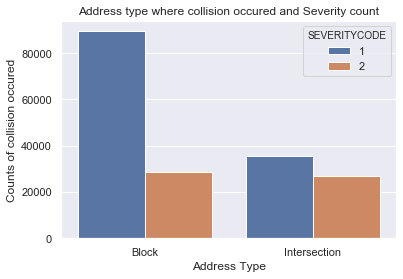

In [71]:
sns.countplot(x="ADDRTYPE", hue="SEVERITYCODE", data=updated_data)
plt.title('Address type where collision occured and Severity count')
plt.xlabel('Address Type')
plt.ylabel('Counts of collision occured')

Text(0, 0.5, 'Counts of collision occured of different types')

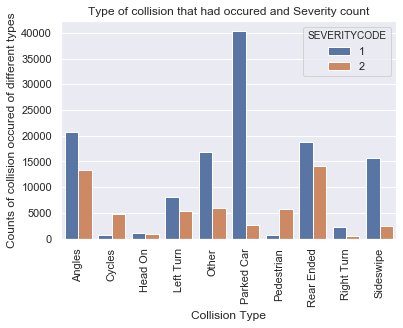

In [72]:
sns.countplot(x="COLLISIONTYPE", hue="SEVERITYCODE", data=updated_data)

plt.title('Type of collision that had occured and Severity count')
plt.xlabel('Collision Type')
plt.xticks(rotation = 90)
plt.ylabel('Counts of collision occured of different types')

Text(0, 0.5, 'Counts of collision occured of different types')

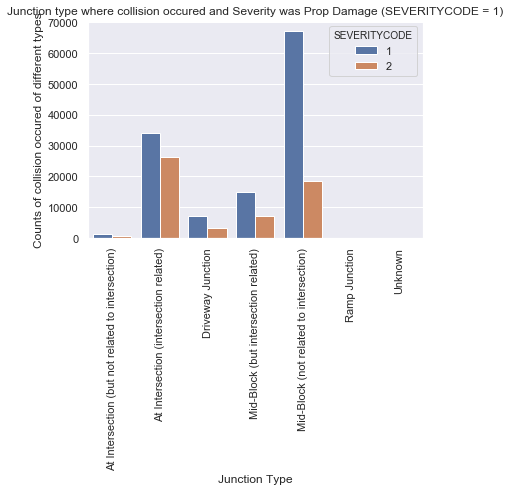

In [73]:
sns.countplot(x="JUNCTIONTYPE", hue="SEVERITYCODE", data=updated_data)
plt.title('Junction type where collision occured and Severity was Prop Damage (SEVERITYCODE = 1)')
plt.xticks(rotation = 90)
plt.xlabel('Junction Type')
plt.ylabel('Counts of collision occured of different types')

Text(0, 0.5, 'Counts of collision occured of different types')

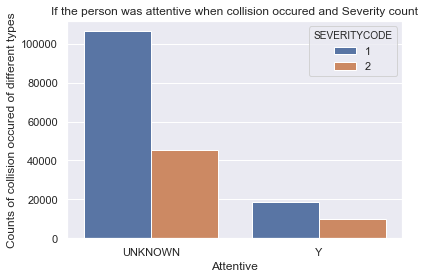

In [74]:
sns.countplot(x="INATTENTIONIND", hue="SEVERITYCODE", data=updated_data)

plt.title('If the person was attentive when collision occured and Severity count')
plt.xlabel('Attentive')
plt.ylabel('Counts of collision occured of different types')

Text(0, 0.5, 'Counts of collision occured of different types')

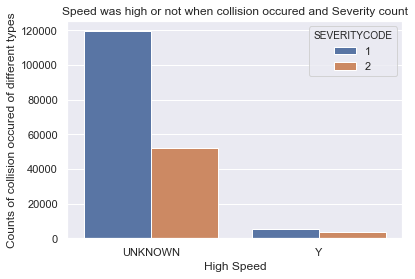

In [75]:
sns.countplot(x="SPEEDING", hue="SEVERITYCODE", data=updated_data)

plt.title('Speed was high or not when collision occured and Severity count')
plt.xlabel('High Speed')
plt.ylabel('Counts of collision occured of different types')

Text(0, 0.5, 'Counts of collision occured of different types')

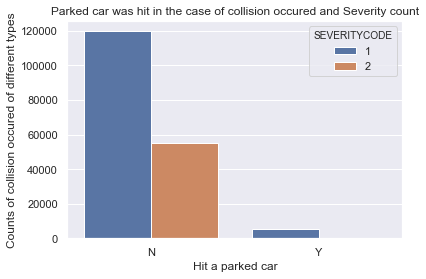

In [76]:
sns.countplot(x="HITPARKEDCAR", hue="SEVERITYCODE", data=updated_data)
plt.title('Parked car was hit in the case of collision occured and Severity count')
plt.xlabel('Hit a parked car')
plt.ylabel('Counts of collision occured of different types')

### ENCODING CATEGORICAL DATA

#### Data types of the features

In [89]:
updated_data.dtypes

ADDRTYPE                      category
LOCATION                      category
COLLISIONTYPE                 category
PERSONCOUNT                      int64
VEHCOUNT                         int64
JUNCTIONTYPE                  category
INATTENTIONIND                category
UNDERINFL                     category
WEATHER                       category
ROADCOND                      category
LIGHTCOND                     category
SPEEDING                      category
HITPARKEDCAR                  category
SEVERITYCODE                     int64
ADDRTYPE_COLLISION            category
COLLISIONTYPE_JUNCTION        category
UNDERINFL_INATTENTION         category
WEATHER_ROADCOND              category
UNDERINFL_HITPARKED           category
UNDERINFL_SPEED               category
LIGHT_ROAD_COND               category
INATTENTION_HITPARKED         category
ADDRTPE_JUNCTION_COLLISION    category
dtype: object

#### Encode

In [90]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
updated_data.ADDRTYPE = le.fit_transform(updated_data.ADDRTYPE)
updated_data.LOCATION = le.fit_transform(updated_data.LOCATION)
updated_data.COLLISIONTYPE = le.fit_transform(updated_data.COLLISIONTYPE)
updated_data.JUNCTIONTYPE = le.fit_transform(updated_data.JUNCTIONTYPE)
updated_data.UNDERINFL = le.fit_transform(updated_data.UNDERINFL)
updated_data.WEATHER = le.fit_transform(updated_data.WEATHER)
updated_data.ROADCOND = le.fit_transform(updated_data.ROADCOND)
updated_data.LIGHTCOND = le.fit_transform(updated_data.LIGHTCOND)
updated_data.SPEEDING = le.fit_transform(updated_data.SPEEDING)
updated_data.HITPARKEDCAR = le.fit_transform(updated_data.HITPARKEDCAR)
updated_data.INATTENTIONIND = le.fit_transform(updated_data.INATTENTIONIND)

updated_data.ADDRTYPE_COLLISION = le.fit_transform(updated_data.ADDRTYPE_COLLISION)
updated_data.COLLISIONTYPE_JUNCTION = le.fit_transform(updated_data.COLLISIONTYPE_JUNCTION)
updated_data.UNDERINFL_INATTENTION = le.fit_transform(updated_data.UNDERINFL_INATTENTION)
updated_data.WEATHER_ROADCOND = le.fit_transform(updated_data.WEATHER_ROADCOND)
updated_data.UNDERINFL_HITPARKED = le.fit_transform(updated_data.UNDERINFL_HITPARKED)
updated_data.UNDERINFL_SPEED = le.fit_transform(updated_data.UNDERINFL_SPEED)
updated_data.LIGHT_ROAD_COND = le.fit_transform(updated_data.LIGHT_ROAD_COND)
updated_data.INATTENTION_HITPARKED = le.fit_transform(updated_data.INATTENTION_HITPARKED)
updated_data.ADDRTPE_JUNCTION_COLLISION = le.fit_transform(updated_data.ADDRTPE_JUNCTION_COLLISION)

### BALANCING THE DATASET

#### Check again if the target data is balanced or not

In [91]:
updated_data.SEVERITYCODE.value_counts()

1    125069
2     55364
Name: SEVERITYCODE, dtype: int64

In [92]:
X = updated_data.drop('SEVERITYCODE', axis = 1)
y = updated_data.SEVERITYCODE

In [93]:
import imblearn

from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
X_samp, y_samp = oversample.fit_sample(X, y)

### MEMEORY USAGE BY DATA

In [94]:
updated_data.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180433 entries, 0 to 182659
Columns: 23 entries, ADDRTYPE to ADDRTPE_JUNCTION_COLLISION
dtypes: int32(20), int64(3)
memory usage: 24.3 MB


In [95]:
updated_data.dtypes

ADDRTYPE                      int32
LOCATION                      int32
COLLISIONTYPE                 int32
PERSONCOUNT                   int64
VEHCOUNT                      int64
JUNCTIONTYPE                  int32
INATTENTIONIND                int32
UNDERINFL                     int32
WEATHER                       int32
ROADCOND                      int32
LIGHTCOND                     int32
SPEEDING                      int32
HITPARKEDCAR                  int32
SEVERITYCODE                  int64
ADDRTYPE_COLLISION            int32
COLLISIONTYPE_JUNCTION        int32
UNDERINFL_INATTENTION         int32
WEATHER_ROADCOND              int32
UNDERINFL_HITPARKED           int32
UNDERINFL_SPEED               int32
LIGHT_ROAD_COND               int32
INATTENTION_HITPARKED         int32
ADDRTPE_JUNCTION_COLLISION    int32
dtype: object

#### Coverting all int64 to uint8

In [96]:
updated_data.ADDRTYPE = updated_data.ADDRTYPE.astype('uint8')
updated_data.LOCATION = updated_data.LOCATION.astype('uint8')
updated_data.COLLISIONTYPE = updated_data.COLLISIONTYPE.astype('uint8')
updated_data.PERSONCOUNT = updated_data.PERSONCOUNT.astype('uint8')
updated_data.VEHCOUNT = updated_data.VEHCOUNT.astype('uint8')
updated_data.JUNCTIONTYPE = updated_data.JUNCTIONTYPE.astype('uint8')
updated_data.UNDERINFL = updated_data.UNDERINFL.astype('uint8')
updated_data.WEATHER = updated_data.WEATHER.astype('uint8')
updated_data.ROADCOND = updated_data.ROADCOND.astype('uint8')
updated_data.LIGHTCOND = updated_data.LIGHTCOND.astype('uint8')
updated_data.SPEEDING = updated_data.SPEEDING.astype('uint8')
updated_data.HITPARKEDCAR = updated_data.HITPARKEDCAR.astype('uint8')
updated_data.SEVERITYCODE = updated_data.SEVERITYCODE.astype('uint8')


updated_data.ADDRTYPE_COLLISION = updated_data.ADDRTYPE_COLLISION.astype('uint8')
updated_data.COLLISIONTYPE_JUNCTION = updated_data.COLLISIONTYPE_JUNCTION.astype('uint8')
updated_data.UNDERINFL_INATTENTION = updated_data.UNDERINFL_INATTENTION.astype('uint8')
updated_data.WEATHER_ROADCOND = updated_data.WEATHER_ROADCOND.astype('uint8')
updated_data.UNDERINFL_HITPARKED = updated_data.UNDERINFL_HITPARKED.astype('uint8')
updated_data.UNDERINFL_SPEED = updated_data.UNDERINFL_SPEED.astype('uint8')
updated_data.LIGHT_ROAD_COND = updated_data.LIGHT_ROAD_COND.astype('uint8')
updated_data.INATTENTION_HITPARKED = updated_data.INATTENTION_HITPARKED.astype('uint8')
updated_data.ADDRTPE_JUNCTION_COLLISION  = updated_data.ADDRTPE_JUNCTION_COLLISION.astype('uint8')

#### After so many changes, creating a copy of the data

In [97]:
formatted_data = updated_data.copy()

### PREPARING DATA FOR MODEL

#### Feature Selection

#### Splitting the data into training and test set for the feature selection

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_samp, y_samp, test_size = 0.2, random_state = 0)

In [99]:
from sklearn.feature_selection import SelectKBest, f_classif

features_cols = formatted_data.columns.drop('SEVERITYCODE')
selector = SelectKBest(f_classif, k =15)

X_new = selector.fit_transform(X_train,y_train)

X_new

array([[ 0,  4,  1, ...,  0, 37, 28],
       [ 1,  0,  5, ...,  0, 44, 55],
       [ 0,  7,  2, ...,  0, 15, 21],
       ...,
       [ 1,  7,  4, ...,  0, 36, 62],
       [ 1,  0,  2, ...,  0, 44, 55],
       [ 0,  7,  3, ...,  0, 44, 31]], dtype=int64)

In [100]:
selected_features = pd.DataFrame(selector.inverse_transform(X_new), columns = features_cols)
selected_features.head()

,ADDRTYPE,LOCATION,COLLISIONTYPE,PERSONCOUNT,VEHCOUNT,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,...,HITPARKEDCAR,ADDRTYPE_COLLISION,COLLISIONTYPE_JUNCTION,UNDERINFL_INATTENTION,WEATHER_ROADCOND,UNDERINFL_HITPARKED,UNDERINFL_SPEED,LIGHT_ROAD_COND,INATTENTION_HITPARKED,ADDRTPE_JUNCTION_COLLISION
0,0,0,4,1,1,4,0,0,7,0,...,0,4,28,1,51,0,0,37,0,28
1,1,0,0,5,2,1,0,0,6,0,...,0,10,1,0,49,0,0,44,0,55
2,0,0,7,2,2,3,0,0,1,0,...,0,7,47,0,6,0,0,15,0,21
3,0,0,4,2,2,4,0,0,1,0,...,0,4,28,0,6,0,0,36,0,28
4,0,0,5,2,2,4,0,0,10,0,...,0,5,35,0,73,0,0,68,0,29


In [101]:
features_selected = selected_features.columns[selected_features.var()!=0]

In [102]:
features_selected

Index(['ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE',
       'WEATHER', 'LIGHTCOND', 'HITPARKEDCAR', 'ADDRTYPE_COLLISION',
       'COLLISIONTYPE_JUNCTION', 'UNDERINFL_INATTENTION', 'WEATHER_ROADCOND',
       'UNDERINFL_SPEED', 'LIGHT_ROAD_COND', 'ADDRTPE_JUNCTION_COLLISION'],
      dtype='object')

#### Splitting the data into training and test set for the model

In [103]:
X = updated_data[features_selected]
y = updated_data.SEVERITYCODE

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

#### Scaling the data

In [104]:
from sklearn.preprocessing import StandardScaler, RobustScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Preparing the model

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn. svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, recall_score, confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [106]:
names = ['K NEAREST NEIGHBOURS','STOCHASTIC GRADIENT DESCENT', 'DECISION TREE CLASSIFIER', 'LOGISTIC REGRESSION', 'RANDOM FOREST CLASSIFIER', 'NAIVE BAYES']
cross_val_scores = []
accuracyscore = []
f1score = []
recallscore = []
roc_aucscore = []

In [107]:
print("\nK NEAREST NEIGHBOURS\n")
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', algorithm='auto', p = 2))
                             ])


cv_scores = cross_val_score(my_pipeline, X, y, cv=5, scoring='accuracy')

cross_val_scores.append(cv_scores.mean())

my_pipeline.fit(X_train, y_train)

y_pred = my_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracyscore.append(accuracy_score(y_test, y_pred))
f1score.append(f1_score(y_test, y_pred))
recallscore.append(recall_score(y_test, y_pred))
roc_aucscore.append(roc_auc_score(y_test, y_pred))




print("\nSTOCHASTIC GRADIENT DESCENT\n")


from sklearn.linear_model import SGDClassifier
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', SGDClassifier(loss="modified_huber", shuffle=True, random_state=101))
                             ])

cv_scores = cross_val_score(my_pipeline, X, y, cv=5, scoring='accuracy')
cross_val_scores.append(cv_scores.mean())

my_pipeline.fit(X_train, y_train)

y_pred = my_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracyscore.append(accuracy_score(y_test, y_pred))
f1score.append(f1_score(y_test, y_pred))
recallscore.append(recall_score(y_test, y_pred))
roc_aucscore.append(roc_auc_score(y_test, y_pred))






print("\n DECISION TREE CLASSIFIER\n")
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', DecisionTreeClassifier(criterion = 'entropy', random_state = 0))
                             ])


cv_scores = cross_val_score(my_pipeline, X, y, cv=5, scoring='accuracy')
cross_val_scores.append(cv_scores.mean())

my_pipeline.fit(X_train, y_train)

y_pred = my_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracyscore.append(accuracy_score(y_test, y_pred))
f1score.append(f1_score(y_test, y_pred))
recallscore.append(recall_score(y_test, y_pred))
roc_aucscore.append(roc_auc_score(y_test, y_pred))






print("\n LOGISTIC REGRESSION\n")
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', LogisticRegression())
                             ])


cv_scores = cross_val_score(my_pipeline, X, y, cv=5, scoring='accuracy')
cross_val_scores.append(cv_scores.mean())

my_pipeline.fit(X_train, y_train)

y_pred = my_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracyscore.append(accuracy_score(y_test, y_pred))
f1score.append(f1_score(y_test, y_pred))
recallscore.append(recall_score(y_test, y_pred))
roc_aucscore.append(roc_auc_score(y_test, y_pred))






print("\n RANDOM FOREST CLASSIFIER\n")
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0))
                             ])


cv_scores = cross_val_score(my_pipeline, X, y, cv=5, scoring='accuracy')
cross_val_scores.append(cv_scores.mean())

my_pipeline.fit(X_train, y_train)

y_pred = my_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracyscore.append(accuracy_score(y_test, y_pred))
f1score.append(f1_score(y_test, y_pred))
recallscore.append(recall_score(y_test, y_pred))
roc_aucscore.append(roc_auc_score(y_test, y_pred))




print("\n NAIVE BAYES\n")
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', GaussianNB())
                             ])


cv_scores = cross_val_score(my_pipeline, X, y, cv=5, scoring='accuracy')
cross_val_scores.append(cv_scores.mean())

my_pipeline.fit(X_train, y_train)

y_pred = my_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracyscore.append(accuracy_score(y_test, y_pred))
f1score.append(f1_score(y_test, y_pred))
recallscore.append(recall_score(y_test, y_pred))
roc_aucscore.append(roc_auc_score(y_test, y_pred))


K NEAREST NEIGHBOURS


STOCHASTIC GRADIENT DESCENT


 DECISION TREE CLASSIFIER


 LOGISTIC REGRESSION


 RANDOM FOREST CLASSIFIER


 NAIVE BAYES



In [108]:
models = pd.DataFrame({'Name' : names, 'CROSS VALIDATION SCORE' : cross_val_scores, 
                       'Accuracy Score' : accuracyscore, 'F1-SCORE' : f1score,
                      'RECALL SCORE' : recallscore, 'ROC AUC SCORE' : roc_aucscore})

models

,Name,CROSS VALIDATION SCORE,Accuracy Score,F1-SCORE,RECALL SCORE,ROC AUC SCORE
0,K NEAREST NEIGHBOURS,0.735220,0.738389,0.829792,0.922786,0.624352
1,STOCHASTIC GRADIENT DESCENT,0.641212,0.721563,0.819504,0.914670,0.602140
2,DECISION TREE CLASSIFIER,0.739288,0.736948,0.829404,0.925320,0.620453
3,LOGISTIC REGRESSION,0.720810,0.724357,0.822691,0.925352,0.600054
4,RANDOM FOREST CLASSIFIER,0.740945,0.738544,0.829626,0.921150,0.625615
5,NAIVE BAYES,0.637965,0.634419,0.710374,0.648767,0.625546


### PERMUTATION IMPORTANCE

In [109]:
import eli5
from eli5.sklearn import PermutationImportance


perm = PermutationImportance(my_pipeline, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = formatted_data[features_selected].columns.tolist())

Weight,Feature
0.0128 ± 0.0013,VEHCOUNT
0.0087 ± 0.0005,PERSONCOUNT
0.0055 ± 0.0010,ADDRTYPE
0.0049 ± 0.0008,UNDERINFL_SPEED
0.0039 ± 0.0007,JUNCTIONTYPE
0.0033 ± 0.0007,UNDERINFL_INATTENTION
0.0029 ± 0.0010,ADDRTPE_JUNCTION_COLLISION
0.0029 ± 0.0008,ADDRTYPE_COLLISION
0.0008 ± 0.0007,HITPARKEDCAR
0.0003 ± 0.0004,COLLISIONTYPE_JUNCTION


In [110]:
features_selected

Index(['ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE',
       'WEATHER', 'LIGHTCOND', 'HITPARKEDCAR', 'ADDRTYPE_COLLISION',
       'COLLISIONTYPE_JUNCTION', 'UNDERINFL_INATTENTION', 'WEATHER_ROADCOND',
       'UNDERINFL_SPEED', 'LIGHT_ROAD_COND', 'ADDRTPE_JUNCTION_COLLISION'],
      dtype='object')

In [111]:
features_perm = ['ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE',
        'HITPARKEDCAR', 'ADDRTYPE_COLLISION', 'COLLISIONTYPE_JUNCTION', 'UNDERINFL_INATTENTION',  
                 'UNDERINFL_SPEED', 'ADDRTPE_JUNCTION_COLLISION']

In [112]:
X = updated_data[features_perm]
y = updated_data.SEVERITYCODE

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [113]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### After selection the best model, tuning the hyperparameters

In [114]:
pca = decomposition.PCA()

# Create a logistic regression object with an L2 penalty
decisiontree = tree.DecisionTreeClassifier()

# Create a pipeline of three steps. First, standardize the data.
# Second, tranform the data with PCA.
# Third, train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('sc', sc),
                       ('pca', pca),
                       ('decisiontree', decisiontree)])

# Create Parameter Space
# Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,X_train.shape[1]+1,1))

# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12]

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(pca__n_components=n_components,
                  decisiontree__criterion=criterion,
                  decisiontree__max_depth=max_depth)

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(pipe, parameters)

# Fit the grid search
clf.fit(X_train, y_train)

# View The Best Parameters
print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['decisiontree'])

Best Criterion: gini
Best max_depth: 12
Best Number Of Components: 11

DecisionTreeClassifier(max_depth=12)


In [116]:
names = ['DECISION TREE CLASSIFIER']
cross_val_scores = []
accuracyscore = []
f1score = []
recallscore = []
roc_aucscore = []

#### Using the parameters obtained above

In [117]:
print("\n DECISION TREE CLASSIFIER\n")
pca = decomposition.PCA(n_components = 11)
my_pipeline = Pipeline(steps=[('sc', sc),
                              ('pca', pca),
                              ('decisiontree', 
                               DecisionTreeClassifier(criterion = 'gini', 
                                                      max_depth = 12,
                                                      random_state = 0))
                             ])


cv_scores = cross_val_score(my_pipeline, X, y, 
                            cv=5,
                            scoring='accuracy')

cross_val_scores.append(cv_scores.mean())

my_pipeline.fit(X_train, y_train)

y_pred = my_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracyscore.append(accuracy_score(y_test, y_pred))

from sklearn.metrics import f1_score, recall_score
f1score.append(f1_score(y_test, y_pred))
recallscore.append(recall_score(y_test, y_pred))

from sklearn.metrics import roc_auc_score
roc_aucscore.append(roc_auc_score(y_test, y_pred))

formatted_data.info(verbose=False, memory_usage="deep")


 DECISION TREE CLASSIFIER

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180433 entries, 0 to 182659
Columns: 23 entries, ADDRTYPE to ADDRTPE_JUNCTION_COLLISION
dtypes: int32(1), uint8(22)
memory usage: 5.9 MB


In [118]:
models = pd.DataFrame({'Name' : names, 'CROSS VALIDATION SCORE' : cross_val_scores, 
                       'Accuracy Score' : accuracyscore, 'F1-SCORE' : f1score,
                      'RECALL SCORE' : recallscore, 'ROC AUC SCORE' : roc_aucscore})

models

,Name,CROSS VALIDATION SCORE,Accuracy Score,F1-SCORE,RECALL SCORE,ROC AUC SCORE
0,DECISION TREE CLASSIFIER,0.748289,0.745949,0.838651,0.95541,0.616411
